# Importing libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import os

# Importing Image Directory

In [4]:
training_images=os.listdir('../input/pins-face-recognition/105_classes_pins_dataset/pins_Adriana Lima/')

# Creating image set and appending into the list

In [5]:
create_train_set=[]
for i in training_images:
    img = image.load_img('../input/pins-face-recognition/105_classes_pins_dataset/pins_Adriana Lima/'+i,target_size=(64,64,3),color_mode= 'rgb',interpolation='nearest')
    img=image.img_to_array(img)
    img=img/255
    create_train_set.append(img)
training_set=np.array(create_train_set)                   
                   
                   

# Function to show image

In [6]:
def show_img(dataset):
    fig, ax = plt.subplots(1,4)
    fig.set_size_inches(40, 20)
    for i in range(4,8):
        ax[i-4].imshow(dataset[i].reshape(64,64,3))
    plt.show()

# Function to add guassian noise/Corrupting image pixels

In [127]:
def gnoise(image):
    row,col,ch= image.shape
    mean = 0
    sigma = 1
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss*0.5
    return noisy
     

In [128]:
gnoise_set=[]
for i in training_set:
    noise=gnoise(i)
    gnoise_set.append(noise)

In [129]:
gnoise_dataset=np.array(gnoise_set)

# Visualizing the corrupted image

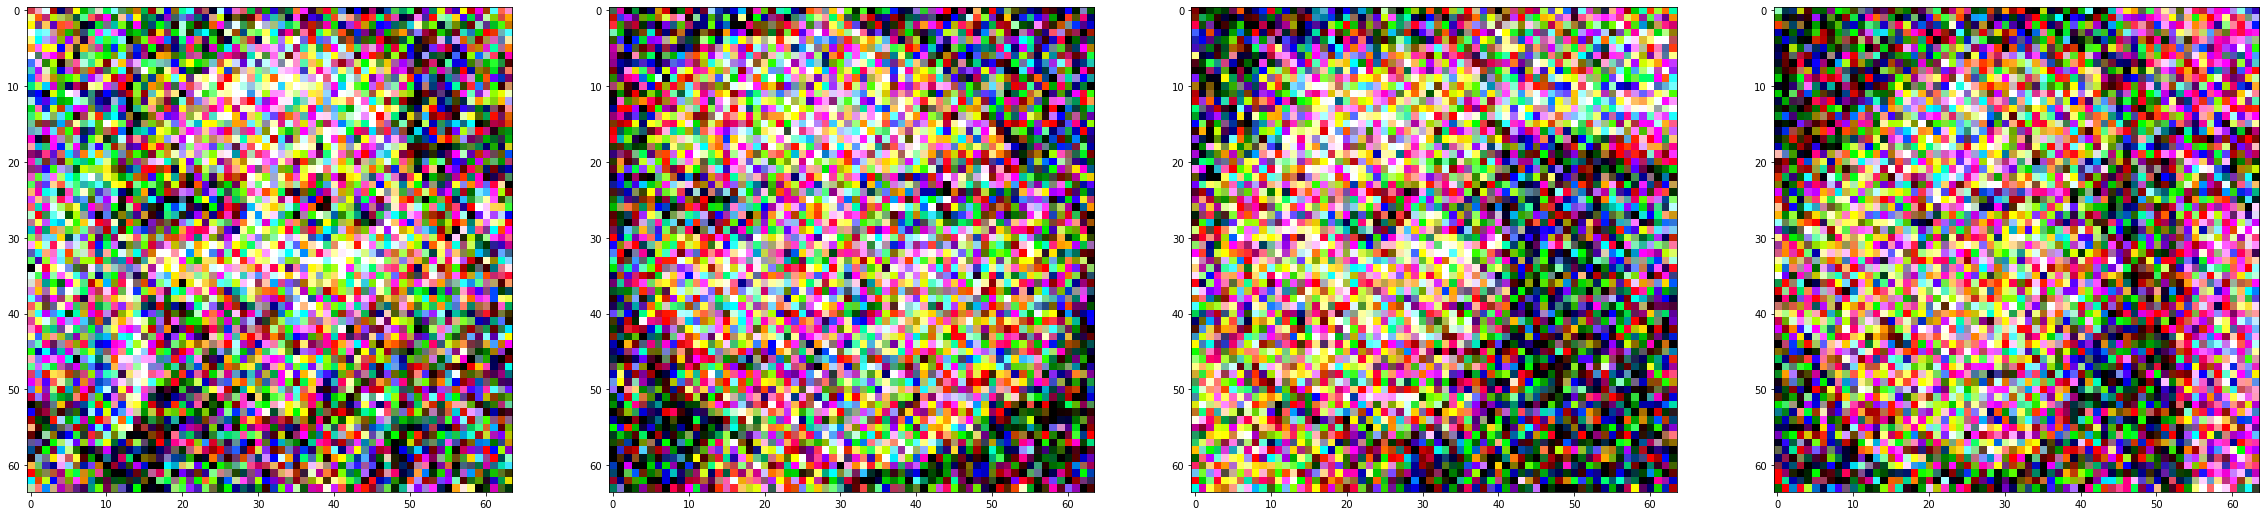

In [130]:
show_img(gnoise_dataset)

# Visualzing the orginal image

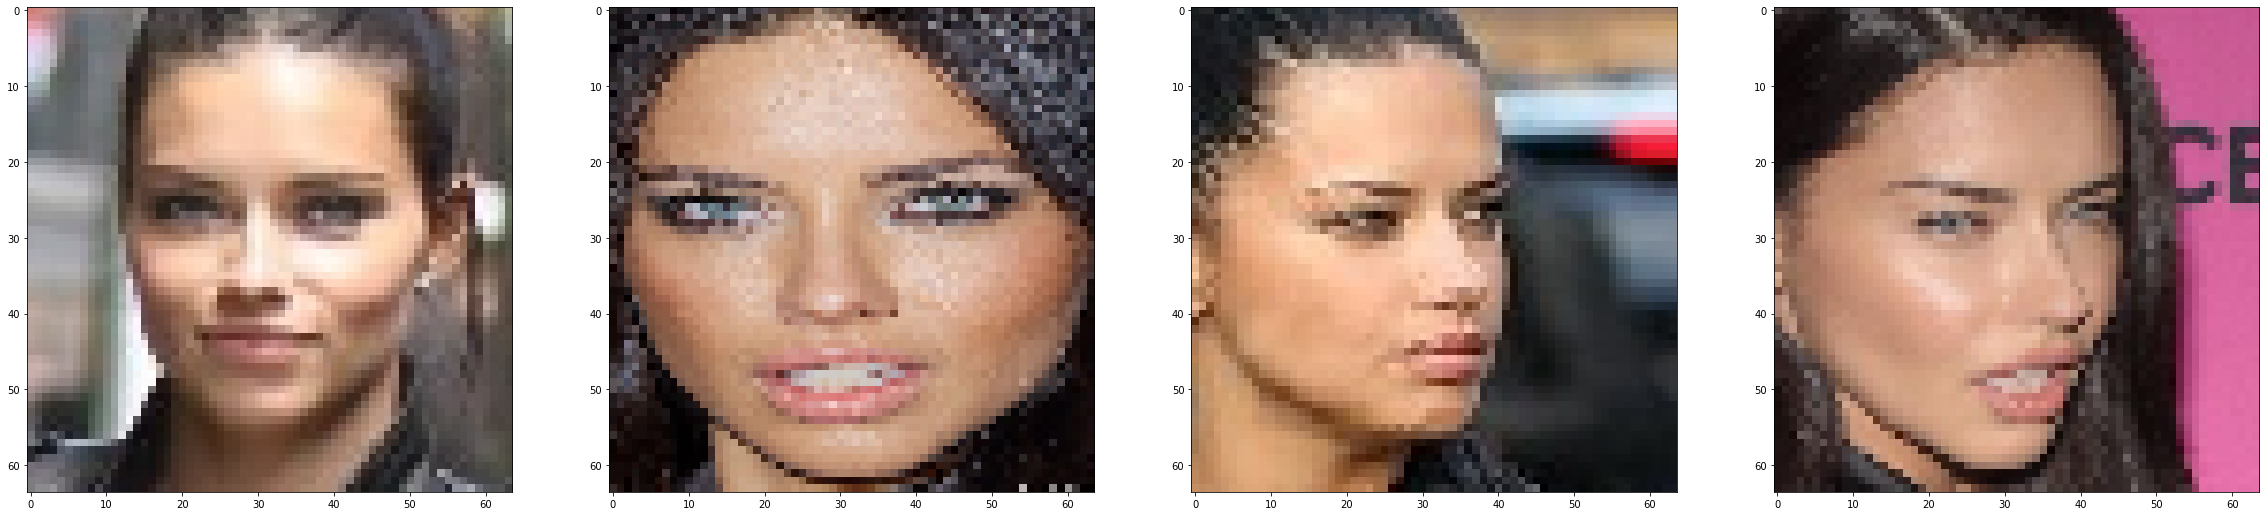

In [131]:
show_img(training_set)

In [132]:
training_set.shape
gnoise_dataset.shape

(213, 64, 64, 3)

# Splitting noisy images into train and test data

In [133]:
xtrainnoisy=gnoise_dataset[0:100]
xtestnoisy=gnoise_dataset[100:]

In [134]:
xtrainnoisy.shape

(100, 64, 64, 3)

# Training the Autoencoder

In [190]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D,Flatten,Input

def autoencoder():
    
    input_img = Input(shape=(64,64,3), name='input_image')
    
 #enoder 
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = MaxPooling2D((2,2), padding='same', name='pool2')(x)
    
    #decoder
    x = Conv2D(512, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = UpSampling2D((2,2), name='upsample1')(x)
    x = Conv2D(514, (3,3), activation='relu', padding='same', name='Conv4')(x)
    x = UpSampling2D((2,2), name='upsample2')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder

In [191]:
model= autoencoder()
model.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 64, 64, 3)]       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 64, 64, 512)       14336     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 32, 32, 512)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 512)       2359808   
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 16, 16, 512)       0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 512)       2359808   
_________________________________________________________________
upsample1 (UpSampling2D)     (None, 32, 32, 512)       0  

In [193]:

model.fit(xtrainnoisy, xtrainnoisy, epochs=150, batch_size=10, validation_data=(xtestnoisy, xtestnoisy))

Epoch 1/150
10/10 [==============================] - 1s 56ms/step - loss: 0.2210 - val_loss: 0.2349
Epoch 2/150
10/10 [==============================] - 0s 50ms/step - loss: 0.2207 - val_loss: 0.2350
Epoch 3/150
10/10 [==============================] - 0s 52ms/step - loss: 0.2205 - val_loss: 0.2353
Epoch 4/150
10/10 [==============================] - 1s 53ms/step - loss: 0.2205 - val_loss: 0.2351
Epoch 5/150
10/10 [==============================] - 1s 55ms/step - loss: 0.2202 - val_loss: 0.2351
Epoch 6/150
10/10 [==============================] - 0s 50ms/step - loss: 0.2201 - val_loss: 0.2355
Epoch 7/150
10/10 [==============================] - 0s 50ms/step - loss: 0.2200 - val_loss: 0.2358
Epoch 8/150
10/10 [==============================] - 0s 50ms/step - loss: 0.2196 - val_loss: 0.2356
Epoch 9/150
10/10 [==============================] - 0s 49ms/step - loss: 0.2193 - val_loss: 0.2358
Epoch 10/150
10/10 [==============================] - 0s 50ms/step - loss: 0.2192 - val_loss: 0.2356

# Predictions

In [199]:
import cv2

def plot_predictions(y_true, y_pred):    
    f, ax = plt.subplots(3, 5)
    f.set_size_inches(11.5,9.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(training_set[i], (64,64,3)), aspect='auto')
        ax[1][i].imshow(np.reshape(gnoise_dataset[i], (64,64,3)), aspect='auto')
        ax[2][i].imshow(np.reshape(y_pred[i], (64,64,3)), aspect='auto')
        
        

**Original, Noisy and Predicted image respectively**

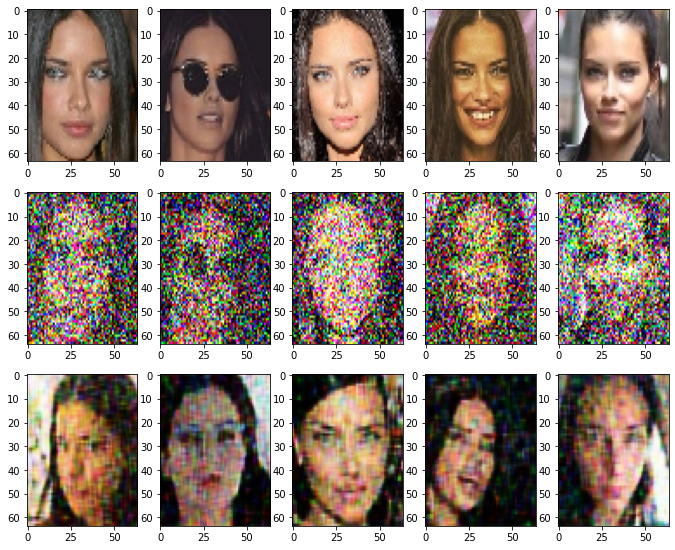

In [200]:
plot_predictions(xtestnoisy[0:7], pred[0:7])

# Comparing orginal, noisy and the predicted image, it is apparent that a huge amount of noise has been removed in the predicted image. Hence our model has learnt important features of the image and has constructed the orginal image from the noisy image by removing the noise